# HW 12: The Big Challenge
## Abigail Kahler, HWRS 582

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = 150 m  

#### Topography
- Bottom of the domain is flat, bottom layer is 40m thick
- Middle layer is also flat, and 5 m thick
- Top layer elevation is provided in BASE_TOP_ELEV_CSV

#### Subsurface Properties: 
- Homogeneous within each of three layers 
- K top and bottom layers = 8.5 m/day in x, y and z.
- K middle layer = same as top and bottom for leftmost 20 columns
- K middle layer: 0.0001 m/day in z direction for rightmost 30 columns 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001   

#### Boundary Conditions: 
 - Right boundary for all layers is defined by a constant head of 70 m relative to the datum (located at bottom of domain).
 - Left, top, and bottom boundaries are no flow.
 
#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.001 m/m
- Streambed rough = 0.04
- Streambed width = 1 m
- Streambed K = 1.36 x horizontal K of top layer
- Streambed thickness = 1 m
- Stream bottom depth = 2 m #to set stream 1 m below ground surface
- Stage = .5 m

#### Well: 
 - Town pumping well
     - Located at row 21, column 38 screened in bottom layer
     - Pumping at a rate of 1500 m^3/day 
     - Some treated water returned to stream at column 25

  - Ag pumping well
    - Screen in top layer, row 12, columns 14
    - Pumping rate = crop water demand plus 20% for excess irrigation
      plus 30% for irrigation efficiency
    - Pumping rate wheat = 3000 m/day
    - Pumping rate pistachios = 4500 m/day
    - Pumping rate cotton = 6000 m/day
     

### 1. Setup the environment

In [3]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from matplotlib import ticker

#jupyter specific--included to show plots in notebook
%matplotlib inline 

### NTNA 2. Setup the input variables 

In [4]:
## model directory
moddir= "C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"

#Initialize the model
modelname1 = "NTNA"    #No Town No Ag = steady state with no pumping from town well
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
nreach = ncol

dx= 1000 #width of grid cells in x direction (m)
dy= 1000 #width of grid cells in y direction (m)
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#Read in surface elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
#surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream
zbot = 0.     #bottom elevation
dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_xyz = 8.5   # m/day horizontal hydraulic conductivity in x, y, z 
K_mid_z = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Boundary condition
h_right = 70  #m

# Recharge in the leftmost columns (zero elsewhere)
recharge = 4e-5 #m/day

### NTNA 3. Setup layer properties and create dis object

In [5]:
## Make some changes to the parameters
#nlay_3lay=3  #two layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45   # bottom elevation of top layer (0) is 45 m 
botm[1,:,:] = 40   # bottom elevation of middle layer (1) is 40 m

## Make arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_xyz                   # assign the original value to the entire array
Kz[1,20:-1,:] = K_mid_z             # assign middle layer Kz in right half of domain

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_xyz                  # assign the original value to the entire array

#Create dis object
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


### NTNA 4. Setup boundary conditions and packages other than stream

In [6]:
# Boundary and initial conditions - bas
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)     #array of ones to make every cell active
ibound[:, :, -1] = -1   #right boundary of constant head
ibound[:,:,0] = 0       #left boundary of no flow
ibound[:,0,:] = 0       #top boundary of no flow
ibound[:,-1,:] = 0      #bottom boundary of no flow

#Impermeable bedrock in upper and lower left of each layer
for i in range(0,9):                     #top layer bedrock
    if i <= 5:
        ibound[0, i, 0:5-i] = 0
        ibound[0, -1-i, 0:5-i] = 0
    elif 6 <= i <= 7:                    #middle layer bedrock
        for j in range(0,7):
            ibound[1, j, 0:7-j] = 0
            ibound[1, -1-j, 0:7-j] = 0
    else:
        for k in range(0,9):             #bottom layer bedrock
            ibound[2, k, 0:9-k] = 0
            ibound[2, -1-k, 0:9-k] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Numerical solver
pcg = flopy.modflow.ModflowPcg(model=m1)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge - background
rech_zone = np.zeros((1,nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,:,0:15] = recharge                   #recharge only occurs in 15 leftmost columns

#Recharge object
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)     #create rch object

#Output control object 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

ET_zone = np.zeros((nrow,ncol))     # create an array of zeroes the size of the model grid
ET_zone[:,25:-1] = 1e-5             # ET only on right half of domain
ET_zone[21:28,:] = 5e-4             # riparian zone ET
extinction_depth = 1                #extinction depth is the depth where if our water table is below that, our ET will be ZERO
evt = flopy.modflow.mfevt.ModflowEvt(model=m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb applies it to water balance

### NTNA 5. Setup stream package

In [7]:
#Setup the stream characteristics
stage_above_datum = 0.5  #given: .5 m above bed
k_strbott = 10           #river bottom hydraulic conductivity in l/t
sed_thick = 1            #thickness of riverbed sediment 

nseg = 3                 # number of segments
ntrib=2                  # two tributaries (for return flow & upstream section)
return_loc = 25          #return flow to the river

slope = 0.001            #slope of streambed (m/m)
rough = 0.04             #roughness of streambed
width = 1.               #width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
Qreturn = 0              #NTNA scenario does not return water to stream

#Define the stream bottom relative to topography (1 m below surface)
for y in range(ncol):
    str_bott = ztop[24,y]-2         #stream bottom is located in row 25 across all columns and below sediment
    str_top = str_bott+sed_thick 

set_icalc = 0    #stage not calculated based on flow  (1 otherwise)
str_spd1 = []    #a list of all cells for river in stress period 1
const = 86400.0  #given multiplication constant for m3/day 
istcb2 = 53      #save outflows to cbb file

#Defining stream reaches
nreach =  50                                    # one reach for every cell across domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row numbers for each reach 
str_cols = np.arange(0,nreach)                  # integer array of col numbers for each reach 

#Setup the inflows for the reaches
reach_flow = np.zeros((nreach),dtype=np.int32)  # create holding array of zeros
reach_flow[return_loc] = Qreturn                # assign return flow value to return flow location
reach_flow[return_loc+1] = -1                   # inflow to seg3 = sum of all previous segments

#Each reach is part of a segment 1,2,or 3
segments = np.ones((nreach),dtype=np.int32)    # array of ones the length of the entire stream
segments[return_loc] = 2                       # the location of town return flow corresponds to segment 2
segments[return_loc+1:nreach] = 3              # everything below return_loc is part of segment 3

#Label reaches 1 through 'n' in each segment 
reaches = np.arange(1,nreach+1)                # an array counting from 1 to 50 (entire length of stream)
reaches[return_loc] = 1                        # the return location is a single cell - single reach - numbered 1
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # begin counting from 1 again after return_loc

# Stream Elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))                 # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

Stop = surf_elev -1                            # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick                        # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage_above_datum          # elevation of the water surface in the stream (m)


#Setup the stress period dictionary
str_info = np.zeros((nreach,13))               # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info}                        # save the stream info in a stress period dictionary


#Setup the segments dictionary
#Each segment has an array of 10 zeros 
#First two vals of segment three are the upstream segment numbers contributing to segment 3
#nseg = 3
icalc = 1
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


### NTNA 6. Plot model grid and boundary conditions

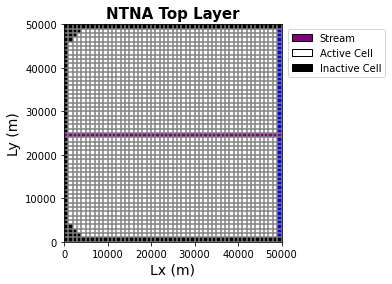

In [8]:
#Plot model grid with stream
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid=modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
plt.title('NTNA Top Layer', fontsize=15, fontweight='bold')
str_m = modelmap.plot_bc('STR')   #plot stream
#wel_m = modelmap.plot_bc('WEL')   #plot well
plt.legend(handles=[#mp.patches.Patch(color='red', label='well', ec='red'),
                   mp.patches.Patch(color='purple',label='Stream', ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

### NTNA 7. Write MODFLOW input files and run model

In [9]:
m1.write_input()    

success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:06:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 20:06:28
 Elapsed run time:  0.126 Seconds

  Normal termination of simulation


### NTNA Attempted cross-sectional head distribution

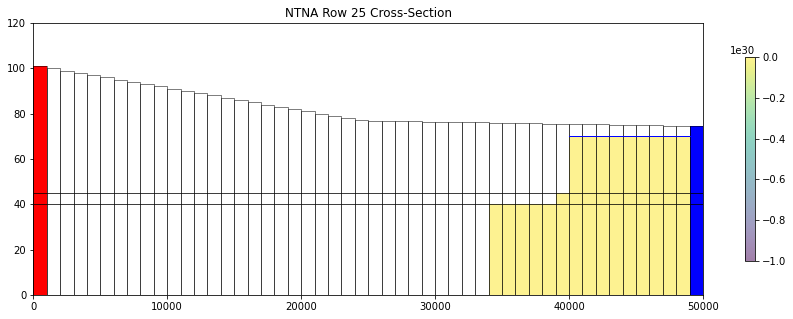

In [13]:
#Plot cross sectional heads
headobj = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj.get_times()                 #returns a list of timesteps
head = headobj.get_data(totim=times[-1])    #returns a numpy array of heads for specified time (last timestep)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}, extent = (0, 50000,0,120)) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head, masked_values=[-999.99], head=head, alpha=0.5)    #set mask to -999.99 for nan error
patches = xsect.plot_ibound(head=head)
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('NTNA Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

#Overlay the head in a layer of the model
wt = xsect.plot_surface(head[0,:,:], masked_values=[-999.99], color='blue', lw=1)

### NTNA Attempted heads and flow vectors map

C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


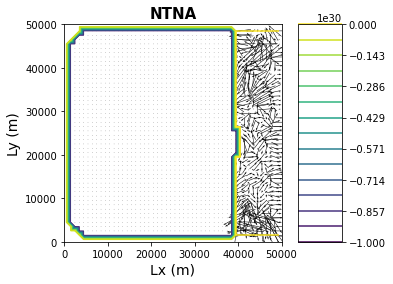

In [16]:
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('NTNA', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

## Start over for Yes Town No Ag (YTNA)